In [1]:
# import things
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from keras.callbacks import EarlyStopping
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import cv2
from patchify import patchify, unpatchify
import sys

sys.path.append(r'/home/y2b/tasks/task2')

import task_2 as t2

2025-01-09 17:41:24.239069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-09 17:41:24.239205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-09 17:41:24.240943: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 17:41:24.255544: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def f1(y_true, y_pred):
    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
# Load the model you trained in task5_training.ipynb
from tensorflow.keras.models import load_model
patch_size = 256
example_file_name = f'tudor_234803_resnet_model_{patch_size}px_iteration2.h5'
model = load_model(example_file_name, custom_objects={"f1": f1})

2025-01-09 17:41:43.451550: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-01-09 17:41:43.452025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3367 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:e1:00.0, compute capability: 8.6


In [4]:
# Define any functions you need to process the mask e.g. Task 2
def crop_image(image, stats, component_index):
    """
    Crops the image to a square around the largest connected component and calculates the cropping offsets.

    Args:
        image (ndarray): The input image.
        stats (ndarray): Component statistics (including bounding box info).
        component_index (int): Index of the component to crop.

    Returns:
        cropped_image (ndarray): The cropped square image.
        crop_info (dict): Amount cropped from each side (left, right, top, bottom).
    """
    x = stats[component_index][0]  # x-coordinate of the top-left corner
    y = stats[component_index][1]  # y-coordinate of the top-left corner
    w = stats[component_index][2]  # width of the bounding box
    h = stats[component_index][3]  # height of the bounding box

    # Determine the size of the square
    size = max(w, h)

    # Calculate the center of the bounding box
    center_x = x + w // 2
    center_y = y + h // 2

    # Calculate the new top-left corner to make the bounding box a square
    new_x = max(center_x - size // 2, 0)
    new_y = max(center_y - size // 2, 0)

    # Ensure the new bounding box does not go out of the image boundaries
    new_x = min(new_x, image.shape[1] - size)
    new_y = min(new_y, image.shape[0] - size)

    # Crop the image
    cropped_image = image[new_y:new_y + size, new_x:new_x + size]
    
    return cropped_image

def crop(img, kernel_size):
    # This function crops an image to the largest connected component (task 2).
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = t2.blur_image(img, kernel_size)
    img_thresh = t2.threshold_image(img_blur)
    num_labels, labels, stats, centroids = t2.connected_components(img_thresh)
    largest_component = t2.get_largest_component(stats)
    img_cropped = crop_image(img, stats, largest_component)
    return img_cropped, stats, centroids, largest_component

def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=0)

    return padded_image

def reverse_crop_image(original_image, cropped_image, stats, component_index):
    """Restores a cropped image back onto a black canvas."""
    x = stats[component_index][0]  # x-coordinate of the top-left corner
    y = stats[component_index][1]  # y-coordinate of the top-left corner
    w = stats[component_index][2]  # width of the bounding box
    h = stats[component_index][3]  # height of the bounding box

    size = max(w, h)
    center_x = x + w // 2
    center_y = y + h // 2
    new_x = max(center_x - size // 2, 0)
    new_y = max(center_y - size // 2, 0)
    new_x = min(new_x, original_image.shape[1] - size)
    new_y = min(new_y, original_image.shape[0] - size)

    restored_image = np.zeros_like(original_image)
    restored_image[new_y:new_y + cropped_image.shape[0], new_x:new_x + cropped_image.shape[1]] = cropped_image

    return restored_image

In [6]:
# Load the test image
task5_test_image_path = 'task5_test_image.png'
image = cv2.imread(task5_test_image_path, 0)
h, w = image.shape
print(image.shape)

(3006, 4112)


In [7]:
# Find the petri dish
petri_dish, stats, centroids, component = crop(image, 5)
petri_dish = np.stack([petri_dish, petri_dish, petri_dish], axis=-1)
petri_dish.shape

(2742, 2742, 3)

In [8]:
# Pad the petri dish
petri_dish_padded = padder(petri_dish, patch_size)
petri_dish_padded = petri_dish_padded / 255
petri_dish_padded.shape

(2816, 2816, 3)

4/4 [==============================] - 0s 58ms/step


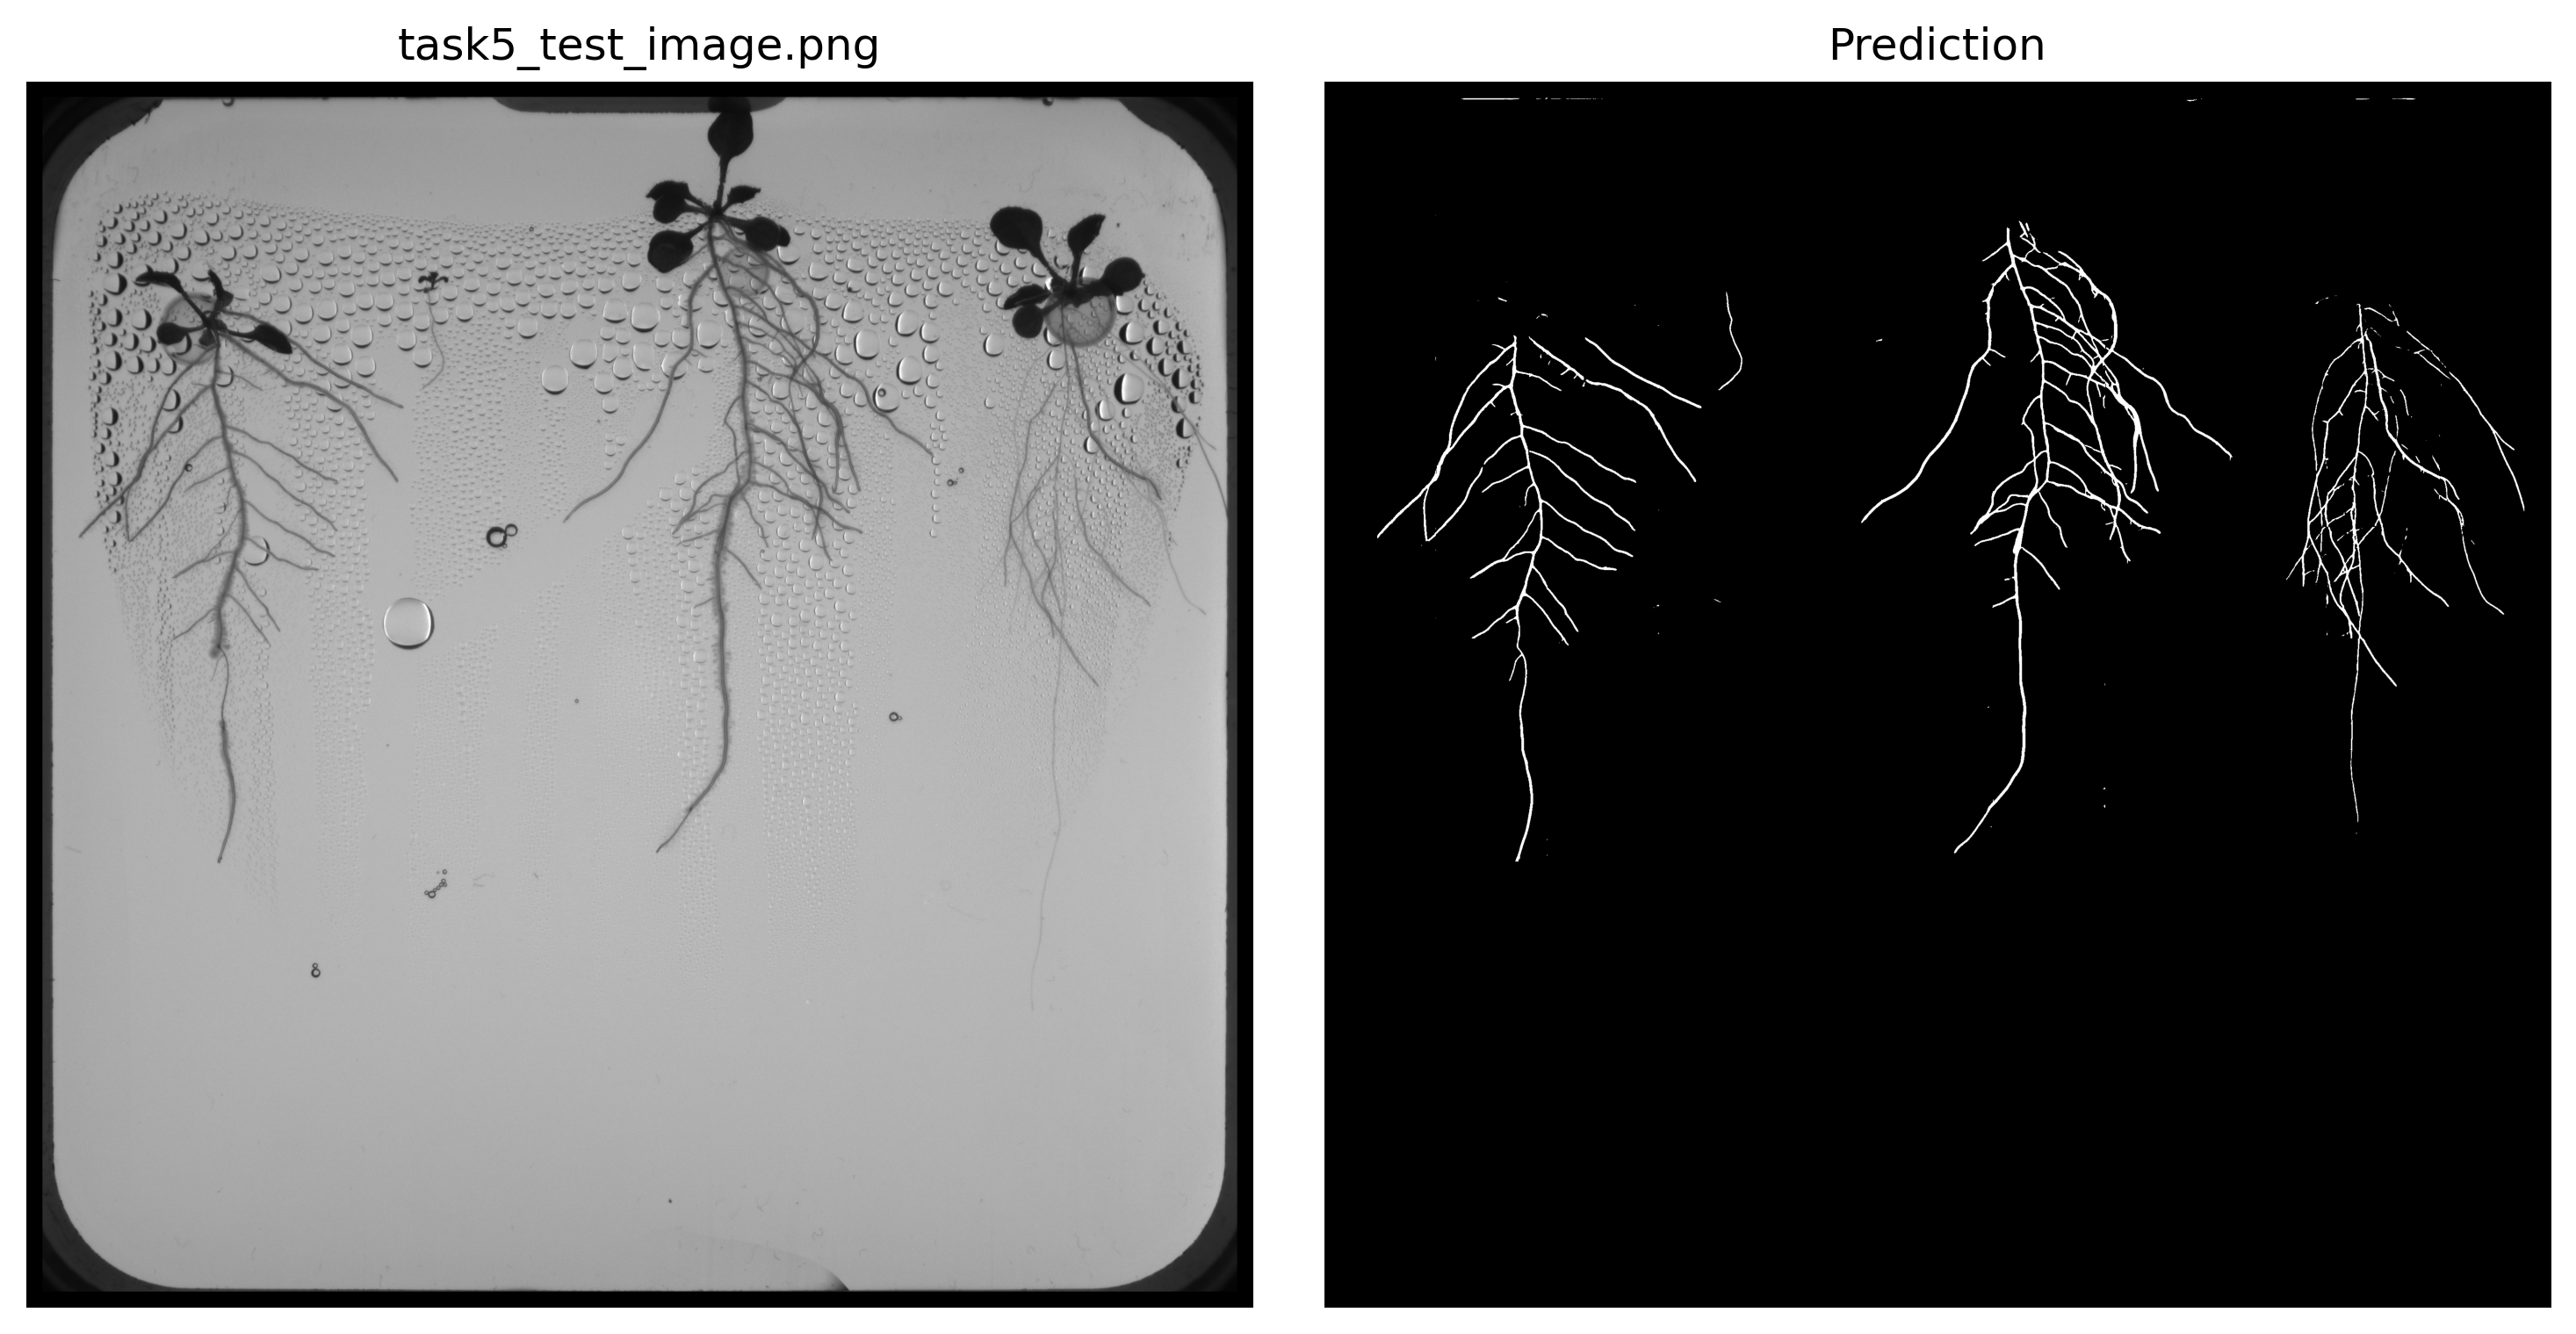

In [11]:
# PATCH
patches = patchify(petri_dish_padded, (patch_size, patch_size, 3), step=patch_size)

#Calculate the expected output shape based on the image and patch sizes
expected_shape = (petri_dish_padded.shape[0] // patch_size, petri_dish_padded.shape[1] // patch_size)

patches_flat = patches.reshape(-1, patch_size, patch_size, 3)

# Predict each patch
predicted_patches = model.predict(patches_flat)

# Correct Reshape (Crucial for unpatchify)
predicted_patches = predicted_patches.reshape(expected_shape[0], expected_shape[1], patch_size, patch_size, predicted_patches.shape[-1])
predicted_patches = predicted_patches[:, :, :, :, 0]

# UNPATCH
original_image_size = (petri_dish_padded.shape[0], petri_dish_padded.shape[1])

predicted_mask = unpatchify(predicted_patches, original_image_size)

predicted_mask = tf.cast(predicted_mask > 0.5, tf.float32)

f, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
ax[0].imshow(petri_dish_padded)
ax[0].axis('off')
ax[0].set_title('task5_test_image.png')

ax[1].imshow(predicted_mask, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Prediction')

plt.tight_layout()
plt.show()

In [12]:
predicted_mask.shape, image.shape

(TensorShape([2816, 2816]), (3006, 4112))

As you can see `predicted_mask` and `image` have different shapes. This is because of cropping and padding.

**REQUIREMENT:** The input and output should have the same size and should be aligned perfectly. To achieve this, you need to reverse the effects of cropping and padding added during processing. This will ensure the final mask aligns with the original image.

(2651, 2651)


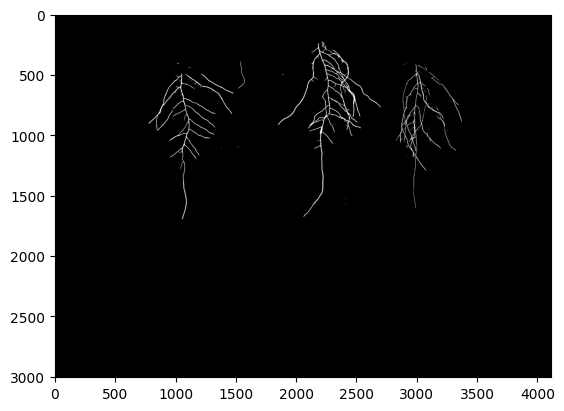

In [13]:
start_index = (3072 - petri_dish.shape[0]) // 2  # This will be the same for both dimensions
predicted_mask = np.array(predicted_mask)
# Crop the image to revert the padding
unpadded = predicted_mask[start_index:start_index + petri_dish.shape[0], 
                             start_index:start_index + petri_dish.shape[1]]

# Now 'cropped_image' should be of shape (2651, 2651)
print(unpadded.shape)
image_temp = image / 255
uncropped = reverse_crop_image(image_temp, unpadded, stats, component)

plt.imshow(uncropped, cmap='gray')

In [14]:
image.shape

(3006, 4112)

In [15]:
uncropped.shape

(3006, 4112)

In [16]:
np.unique(uncropped)

array([0., 1.])

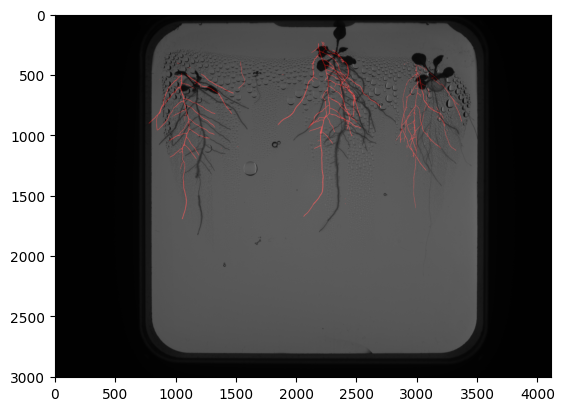

In [17]:
image = image / 255.0
image = image.astype(np.float32)

# Create a color overlay
color_overlay = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.float32)

# Assign the uncropped mask to the red channel of the color overlay
color_overlay[:, :, 0] = uncropped  # Assign to the red channel directly

# Expand dimensions of the grayscale image to match the shape of the color overlay
image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
# Combine the image and overlay
alpha = 0.5
combined_image = (1 - alpha) * color_overlay + alpha * image

# Clip values to ensure they are in the valid range for display
combined_image = np.clip(combined_image, 0, 1)

# Plot the combined image
plt.figure()
plt.imshow(combined_image)
plt.show()

# Restore the original grayscale image to its uint8 format
image = (image * 255).astype(np.uint8)

In [18]:
# REQUIREMENT: Save the predicted mask, it is a deliverable.
# REQUIREMENT: Input/Output size must be the same.
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: The predicted mask must be binary.
# REQUIREMENT: Non-root pixels must be 0, root pixels must be 255 (unlike Task 1)
# REQUIREMENT: naming convention task5_test_image_prediction_studentname_studentnumber.png
uncropped = np.stack((uncropped,)*3, axis=-1)
uncropped= uncropped * 255
assert(uncropped.shape == image.shape)
cv2.imwrite('task5_test_image_prediction_tudor_234803_resnet_iteration2.png', uncropped)

True

Note: I have trained the model on the Y2B_23 dataset, since there are no labels for Y2B_24 dataset yet. The test image is from Y2B_24, this is why the predicted mask is suboptimal. Therefore do not take the performance of this prediction as a reference. Your predictions should be much better than this.